# Proyecto Final 
------

* Por Ramón Escobar 
* Ciencia de Datos en Python I (Abril 2021)
* Universidad Galileo - Guatemala

In [1]:
#Librerias
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
from sklearn.linear_model import LinearRegression
style.use('ggplot')

## Carga de datos y Sets de entrenamiento y validación

In [2]:
data = np.load('proyecto_training_data.npy', allow_pickle = False)
data.shape

(1460, 6)

In [3]:
pct = int(data.shape[0]*0.8)
np.random.shuffle(data)

train, test = data[:pct], data[pct:]
train.shape, test.shape

((1168, 6), (292, 6))

In [4]:
data = pd.DataFrame(data, 
             columns = ['SalePrice', 'OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

train = pd.DataFrame(train, 
             columns = ['SalePrice', 'OverallQual','1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

test = pd.DataFrame(test, 
             columns = ['SalePrice','OverallQual', '1stFlrSF','TotRmsAbvGrd','YearBuilt','LotFrontage'])

## Descriptivos de datos

In [5]:
data.describe()

,SalePrice,OverallQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1201.000000
mean,180921.195890,6.099315,1162.626712,6.517808,1971.267808,70.049958
std,79442.502883,1.382997,386.587738,1.625393,30.202904,24.284752
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,129975.000000,5.000000,882.000000,5.000000,1954.000000,59.000000
50%,163000.000000,6.000000,1087.000000,6.000000,1973.000000,69.000000
75%,214000.000000,7.000000,1391.250000,7.000000,2000.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


In [6]:
rango_p2p = data.max() - data.min()
rango_p2p

SalePrice       720100.0
OverallQual          9.0
1stFlrSF          4358.0
TotRmsAbvGrd        12.0
YearBuilt          138.0
LotFrontage        292.0
dtype: float64

## Histogramas

In [7]:
def hist_dimensions(data, dimension):
    plot = sns.displot(data = data, x = dimension)
    plt.title(dimension)
    plt.xlabel(dimension, fontsize = 12)
    plt.ylabel('Conteo', fontsize = 12)
    plt.show()

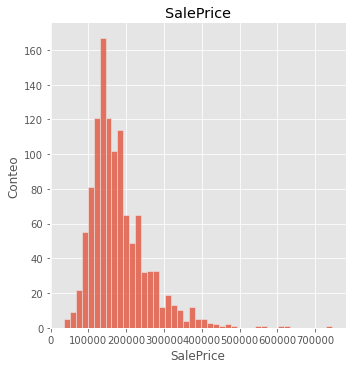

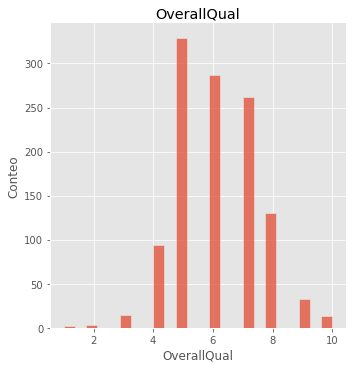

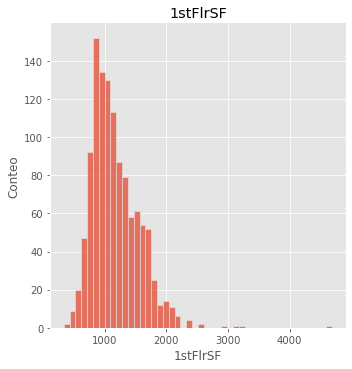

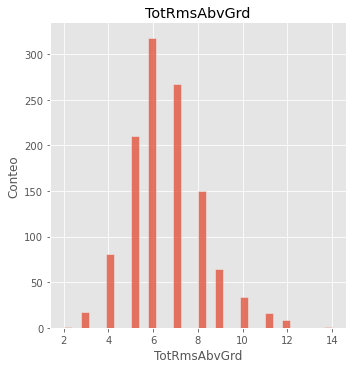

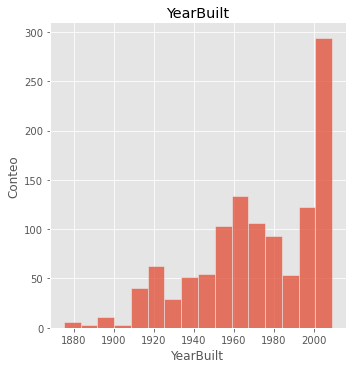

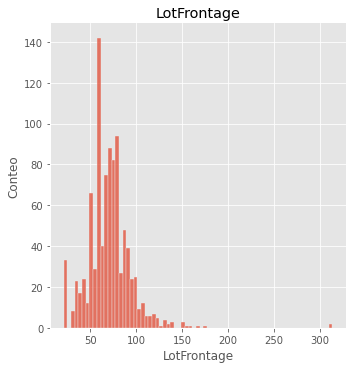

In [8]:
for i in data.columns.to_list():
    hist_dimensions(train, i)

## Correlaciones

In [9]:
def correlations_xy(data, x_dim, y_dim):
    corr = (pd.DataFrame(data[[x_dim, y_dim]]).corr().iloc[0,1])
    plt.figure(figsize = (6,3))
    plt.scatter(data = data, x = x_dim, y = y_dim)
    plt.title(str(x_dim)+' vs '+ str(y_dim) + ' | Corr:'+str((round(corr,4))), fontsize = 12)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.show()
    return round(corr,4)

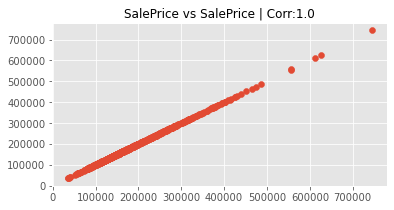

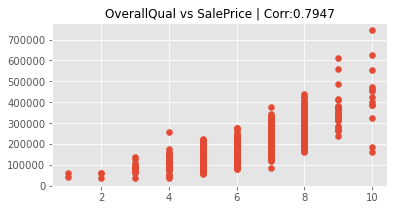

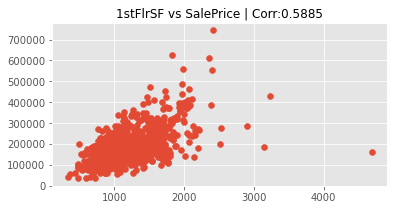

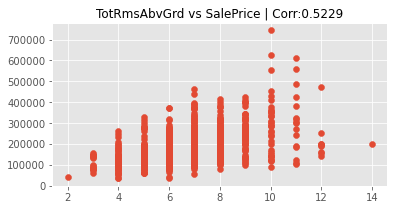

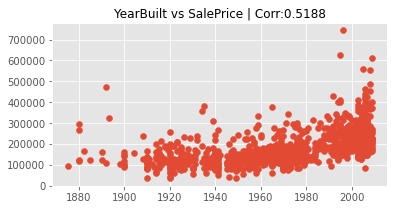

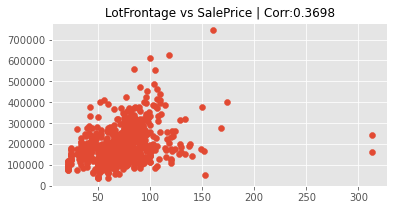

In [10]:
variables = []
correlations = []
for i in data.columns.to_list():
    variables.append(i)
    correlations.append(correlations_xy(train, i, 'SalePrice'))

In [11]:
top_corr_variables = pd.DataFrame({'Variables':variables, 
                                   'Correlaciones':correlations})
top_corr_variables.sort_values(by='Correlaciones', ascending = False)[1:3]

,Variables,Correlaciones
1,OverallQual,0.7947
2,1stFlrSF,0.5885


Basado en esta información, **OverallQual y 1stFlrFS** son las candidatas a ser las variables con mayor poder predictivo

In [12]:
train_OverallQual = np.array(train['OverallQual']) 
train_1stFlrSF = np.array(train['1stFlrSF'])
train_SalePrice = np.array(train['SalePrice'])

## Regresión

In [13]:
class univ_linear_reg():
    def __init__(self, x, y, epochs = 1000, imprimir_error_cada=100, learning_rate = 0.001 ):
        
        self.imprimir_error_cada = imprimir_error_cada
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.x_original = x
        self.vect_ones = np.ones_like(x).reshape(-1,1)
        
        self.xr = np.reshape(x,(-1,1))
        self.xr = np.hstack([self.xr,self.vect_ones])
        self.yr = np.reshape(y, (-1,1))
        
        #inicializando betas  
        self.b0 = np.random.default_rng().normal(np.average(self.x_original), np.std(self.x_original))
        self.b1 = np.random.default_rng().normal(np.average(self.yr), np.std(self.yr))

        self.betas = np.array([[self.b1],[self.b0]])
        
        #inicilizando almacenamiento de errores y modelo
        self.errors = []
        self.models = {}
        
        for i in range(0, self.epochs):
            #Predicciones
            self.y_pred = np.matmul(self.xr, self.betas)
            
            #Calculo del error
            self.e = 1/(2*self.yr.shape[0]) * np.sum((self.yr - self.y_pred)**2)
            self.errors.append(self.e)
            
            self.models[i] = [self.betas, self.y_pred, self.yr, self.x_original]

            #calculando gradientes
            self.gradient = (1/self.yr.shape[0]) * sum((self.y_pred - self.yr)*self.xr)
            self.mult_gradient = (self.learning_rate*self.gradient)
            self.mult_gradient = self.mult_gradient.reshape((-1,1))

            #Actualizando Betas
            self.betas = self.betas - self.mult_gradient

            #Imprimiendo resultados cada n veces
            if i%self.imprimir_error_cada==0:
                print('Iteración: ', i)
                print('Error: ',self.e)
                print("")
        
    def trained_models(self):
        return self.models , np.array(self.errors)
    
    def predictions(self, x_rp):
        self.x_rp = x_rp
        self.vect_ones_xp = np.ones_like(self.x_rp).reshape(-1,1)
        self.xp = np.reshape(self.x_rp,(-1,1))
        self.xp = np.hstack([self.xp,self.vect_ones_xp])
        
        self.yp = np.matmul(self.xp, self.betas)
        return self.yp

    @staticmethod
    def error_predictions(ypp, ypr):
        ep = 1/(2*ypp.shape[0]) * np.sum((ypr - ypp)**2)
        return ep
    
    @staticmethod
    def error_plot(errors):
        plt.figure(figsize = (10,5))
        plt.plot(errors)
        plt.title("Errores del modelo", fontsize = 12)
        plt.xlabel("Epoch", fontsize = 10)
        plt.ylabel("Errores")
        plt.xticks(fontsize = 10)
        plt.yticks(fontsize = 10)
        plt.show()
        
    @staticmethod
    def model_plot(models_t,n):
        fig = plt.figure(figsize = (10,5))
        ax =  fig.add_axes([0.1,0.1,0.7,0.7])
        ax.set_title('Comparativa de modelos')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        i = 0
        for k in models_t.keys():
            if k%n == 0 and k != 0:
                ax.scatter(x = models_t[k][3], y = models_t[k][2], color = '#CDCDCD')
                ax.plot(models_t[k][3],  models_t[k][1], linestyle ='solid', color ='#93b5d9')

            if k == max(models_t.keys()):
                ax.plot(models_t[k][3],  models_t[k][1], linestyle ='solid', color ='#0051ff')
                ax.text(max(models_t[k][3]),max(models_t[k][1])+100, 'Modelo '+str(k), fontsize='small')
        plt.show()
        
    @staticmethod
    def betas_plot(models):
        b0 = []
        b1 = []
        for k in models.keys():
            b1.append(models[k][0][0])
            b0.append(models[k][0][1])
        fig = plt.figure(figsize = (10,5))
        ax =  fig.add_axes([0.1,0.1,0.7,0.7])
        ax.plot(b0)
        ax.plot(b1)
        ax.legend(['B0','B1'])
                
    @staticmethod
    def model_comparative(model1, model2 , x):
        #predicciones del modelo propio
        result_m1 = model1.predictions(x)
        #predicciones de sklearn
        result_m2 = model2.predict(x.reshape(-1,1))        
        #promedio de ambos modelos
        avg_result = (result_m1 + result_m2)/2
        return result_m1, result_m2, avg_result
    
    @staticmethod
    def ploting_error_models(modelos, y):
        i = 0
        labels = []
        e_modelos = []
        for r in modelos:
            i +=1
            e_modelos.append(univ_linear_reg.error_predictions(r, y))
            labels.append('Modelo'+str(i) + '\n'+str(round(univ_linear_reg.error_predictions(r, y),0)))
        fig, ax = plt.subplots()
        ax.bar(labels, e_modelos)
        fig.tight_layout()
        plt.show()

## Entrenando modelos de regresión - con OverallQual

In [14]:
m1 = univ_linear_reg(train_OverallQual, 
                     train_SalePrice, 
                     10001,2000,0.01)
m1_modelos, m1_errores = m1.trained_models()    

Iteración:  0
Error:  1323400334504.7532

Iteración:  2000
Error:  1087639341.094766

Iteración:  4000
Error:  1080206955.0560603

Iteración:  6000
Error:  1079106939.1471753

Iteración:  8000
Error:  1078944133.4218674

Iteración:  10000
Error:  1078920037.6756337



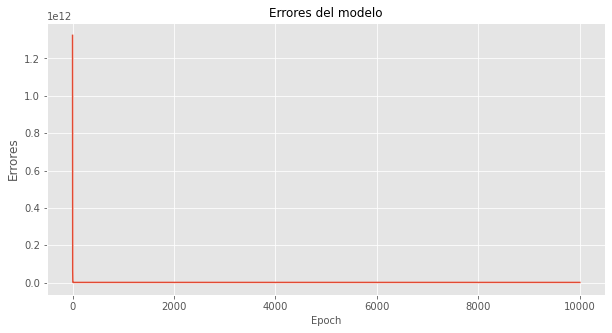

In [15]:
univ_linear_reg.error_plot(m1_errores)

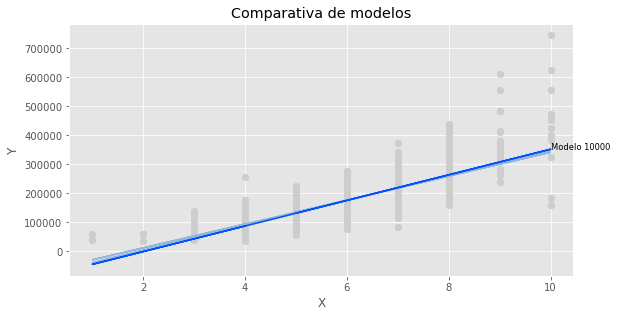

In [16]:
univ_linear_reg.model_plot(m1_modelos, 2000)

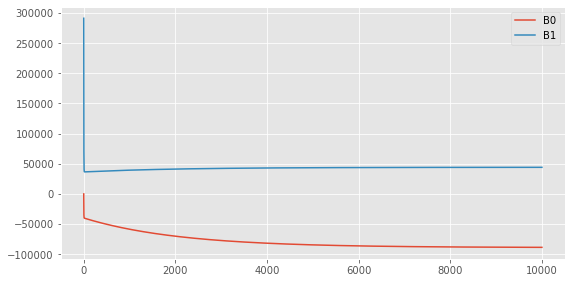

In [17]:
univ_linear_reg.betas_plot(m1_modelos)

## Entrenando modelos de regresión - con 1stFlrSF

In [18]:
m2 = univ_linear_reg(train_1stFlrSF, 
                     train_SalePrice, 
                     51,10,0.000001)

m2_modelos, m2_errores = m2.trained_models()   

Iteración:  0
Error:  1.0749938940847352e+16

Iteración:  10
Error:  18779398969.33206

Iteración:  20
Error:  2004804534.2196817

Iteración:  30
Error:  2004778178.0346

Iteración:  40
Error:  2004777997.5394742

Iteración:  50
Error:  2004777817.0855553



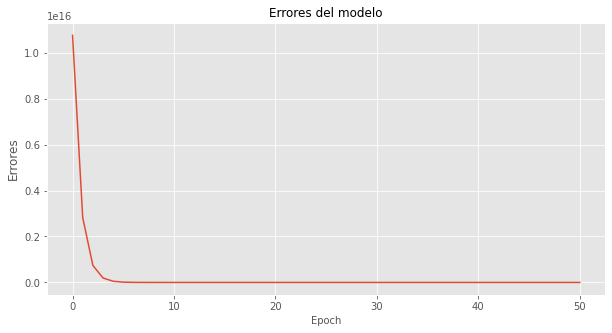

In [19]:
univ_linear_reg.error_plot(m2_errores)

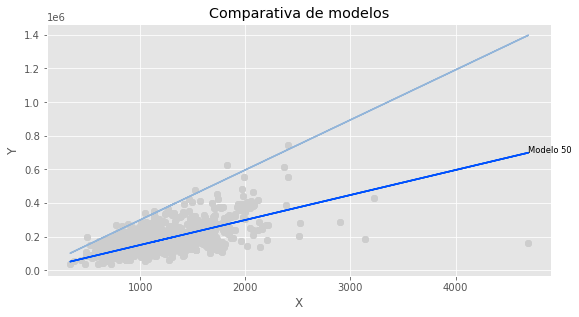

In [20]:
univ_linear_reg.model_plot(m2_modelos, 10)

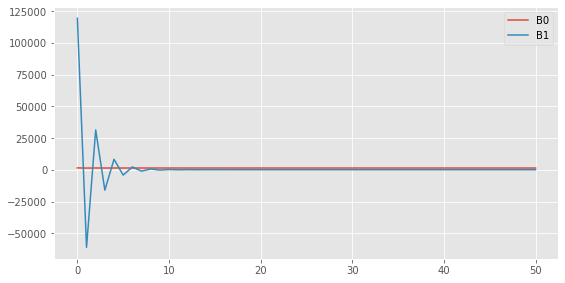

In [21]:
univ_linear_reg.betas_plot(m2_modelos)

## Predicciones modelo propio vs SK-Learn

### Entrenamiento con Scikit Learn

In [22]:
skm1 = LinearRegression().fit(train_OverallQual.reshape(-1,1), train_SalePrice.reshape(-1,1))
skm2 = LinearRegression().fit(train_1stFlrSF.reshape(-1,1), train_SalePrice.reshape(-1,1))

### Predicciones con modelo propio, Scikit Learn y Promedio

In [23]:
test_OverallQual = np.array(test['OverallQual'])
test_1stFlrSF = np.array(test['1stFlrSF'])
test_SalePrice = np.array(test['SalePrice'])

In [24]:
modelos_OverallQual = univ_linear_reg.model_comparative(m1, skm1, test_OverallQual)
modelos_1stFlrSF = univ_linear_reg.model_comparative(m2, skm2, test_1stFlrSF)

## Comparando modelos 

- Modelo 1 - Modelo Propio
- Modelo 2 - Modelo Scikit Learn
- Modelo 3 - Modelo Promedio

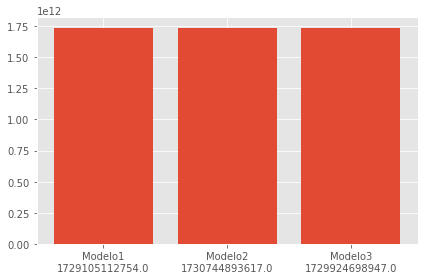

In [25]:
univ_linear_reg.ploting_error_models(modelos_OverallQual, test_SalePrice)

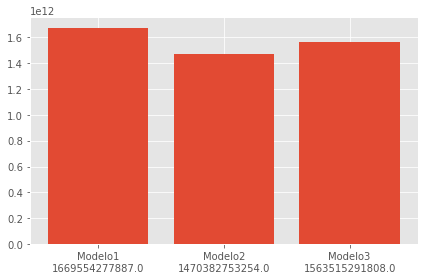

In [26]:
univ_linear_reg.ploting_error_models(modelos_1stFlrSF, test_SalePrice)

- **OverallQual**: todos los modelos tienen un error con el 20% de la data muy similar, pero la regresión creada para esta tarea es el modelo con con menor error  
- **1stFlrSF**: el mejor modelo es la regresión de scikit learn, con un error significativemente menor al modelo generado en esta tarea